In [1]:
pip install torch

In [2]:
pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.6 MB/s eta 0:00:00


In [29]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.4 MB/s eta 0:00:00


In [3]:
pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 4.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [5]:
X_test_signi = pd.read_csv('X_test_signi.csv')
X_train_signi = pd.read_csv('X_train_signi.csv')
y_test = pd.read_csv('Y_test.csv')
y_train = pd.read_csv('Y_train.csv')

In [6]:
X_test_signi.shape, X_train_signi.shape, y_test.shape, y_train.shape

((14151, 141), (56582, 141), (14151, 2), (56582, 2))

In [7]:
X_test_signi.drop(columns="Unnamed: 0", inplace=True)
X_train_signi.drop(columns="Unnamed: 0", inplace=True)
y_train.drop(columns="Unnamed: 0", inplace=True)
y_test.drop(columns="Unnamed: 0", inplace=True)

# ANN using SelectKBest feature selection

In [42]:
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression


def select_k_features(k_top, X_train, Y_train, X_test):

 select_model = SelectKBest(score_func=mutual_info_regression, k=k_top)
 select_model.fit(X_train, Y_train)
 chosen_indices = select_model.get_support(indices=True)
 column_names = X_train.columns
 selected_column_names = column_names[chosen_indices]
 print('-'*50)
 print('selected features using mutual_info_regression')
 print('-'*50)
 print(selected_column_names)
 X_train_select = X_train[selected_column_names]
 X_test_select = X_test[selected_column_names]


 return X_train_select, X_test_select

In [43]:
X_train_select, X_test_select = select_k_features(33, X_train_signi, y_train, X_test_signi)

--------------------------------------------------
selected features using mutual_info_regression
--------------------------------------------------
Index(['10', '72', '2', '1', '67', 'florist', '77', '8', 'salad_bar',
       'coffee_bar', '4', '75', '79', 'meat_sqft', 'frozen_sqft', '12',
       'prepared_food', '11', '69', '5', 'store_sqft', '226', '218', '219',
       '223', '225', 'store_type', '222', '73', '220', 'grocery_sqft', '227',
       '224'],
      dtype='object')


X_train and X_test are already split in the ration 80:20, hence we should divide X_train and X_valid in the ratio 75:25 so that finally 60:20:20 ratio is maintained

In [35]:
from sklearn.model_selection import train_test_split

def get_valid_from_train(X_train,Y_train):
  X_train,X_valid,y_train,y_valid=train_test_split(X_train,Y_train,test_size=0.25,random_state=1)

  return X_train,X_valid,y_train,y_valid

In [44]:
X_train,X_valid,y_train,y_valid=get_valid_from_train(X_train_select,y_train)

In [45]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_valid = X_valid.to_numpy()
y_valid = y_valid.to_numpy()

# Convert numpy array to 2D tensors of pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)

In [22]:
import copy

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torcheval.metrics import R2Score

In [47]:
import torch.nn as nn

# lets define the model
ann_model = nn.Sequential(
    nn.Linear(33, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [48]:
# MSE is the chosen loss function, Adam optimizer is the chosen optimizer
loss_func = nn.MSELoss()  # mean square error
optimize = optim.Adam(ann_model.parameters(), lr=0.00001)

# store the best parameters of the model
bestMSE = np.inf   # initially set the MSE to infinity
bestWeights = None
bestR2 = -np.inf
historyR2 = []
metric = R2Score()
history = []

n_epochs = 100   # the number of iterations/epochs to loop/run
batch = 32  # batch size(the data is divided into mini-batches of size 32)
batchstart = torch.arange(0, len(X_train), batch)

MSE: 4332.74
RMSE: 65.82
R2: -0.02


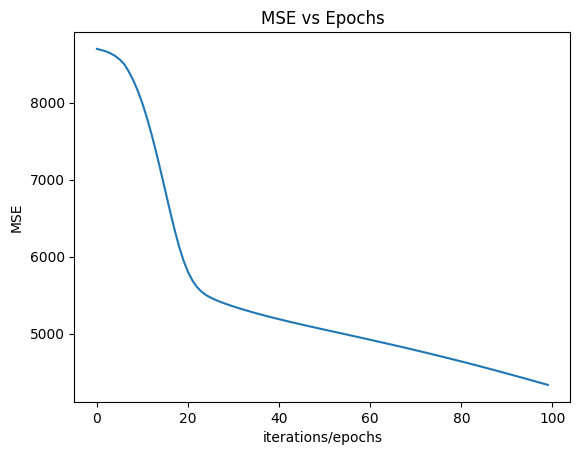

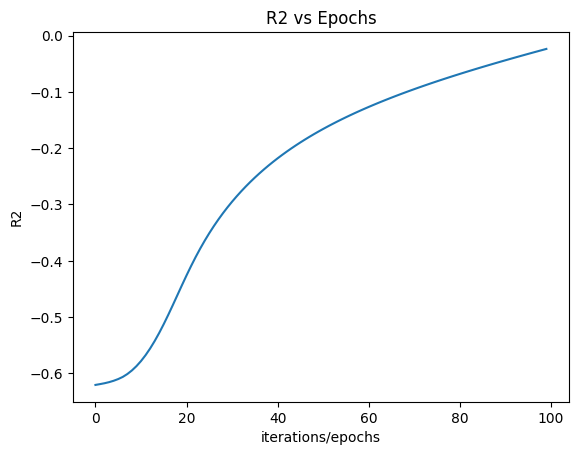

In [49]:
for epoch in range(n_epochs):
    ann_model.train()
    with tqdm.tqdm(batchstart, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch]
            y_batch = y_train[start:start+batch]
            # forward pass
            y_pred = ann_model(X_batch)
            loss = loss_func(y_pred, y_batch)
            # backward pass
            optimize.zero_grad()
            loss.backward()
            # update weights
            optimize.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    ann_model.eval()
    y_pred = ann_model(X_valid)
    mse = loss_func(y_pred, y_valid)
    mse = float(mse)
    metric.update(y_pred, y_valid)
    r2 = metric.compute()
    history.append(mse)
    historyR2.append(r2)
    if mse < bestMSE:
        bestMSE = mse
        bestWeights = copy.deepcopy(ann_model.state_dict())
    if r2 > bestR2:
        bestR2 = r2


# restore model and return best accuracy
ann_model.load_state_dict(bestWeights)
print("MSE: %.2f" % bestMSE)
print("RMSE: %.2f" % np.sqrt(bestMSE))
print("R2: %.2f" % bestR2)
plt.plot(history)
plt.xlabel('iterations/epochs')
plt.ylabel('MSE')
plt.title('MSE vs Epochs')
plt.show()
plt.plot(historyR2)
plt.xlabel('iterations/epochs')
plt.ylabel('R2')
plt.title('R2 vs Epochs')
plt.show()

The R2 score using SelectKBest feature selection is negative the developed regression model is not good. Now lets try with PCA feature extraction

# ANN using PCA feature extraction

First let us plot cumulative variance and scree plot to understand the variance in each of the principle components.

In [10]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA()
pca.fit(X_train_signi)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

We can try three PCA variability values [80, 85, 90] to check how ANN performs

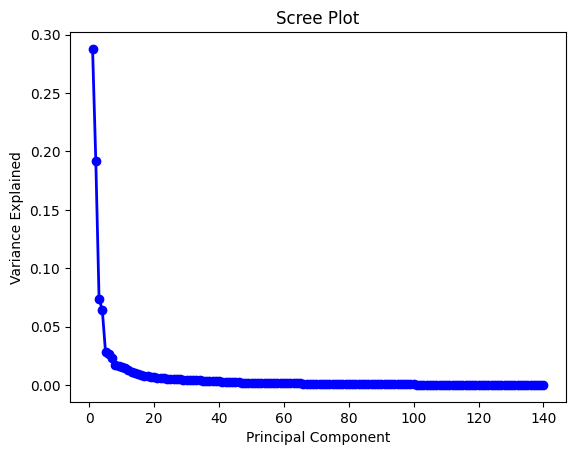

In [43]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [8]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from skorch import NeuralNetRegressor
from torcheval.metrics import R2Score
from sklearn.model_selection import GridSearchCV

In [9]:
from sklearn.decomposition import PCA

def pca_dim_reduction(X_train,X_test, variability):
    pca=PCA(variability)
    X_pca_train=pca.fit_transform(X_train)
    X_pca_test=pca.transform(X_test)
    return X_pca_train, X_pca_test

In [10]:
# converting dataframe into numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# ANN with different number of PCA components but fixed batch size, learning rate and epochs

This is done to identify the number of PCA components to use in ANN modeling. By rule of thumb, it is good to consider at least 80% variability with PCA. Let us build an ANN model with 0.80, 0.85, and 0.90 variances and select the variance which produces the best R2 score

In [32]:
PCA_variability = [0.80, 0.85, 0.90]
for var in PCA_variability:
  variability = var

  # dimension reduction using PCA
  X_pca_train, X_pca_test=pca_dim_reduction(X_train_signi,X_test_signi, variability)

  print('X_train and X_test shape after PCA with variability = ', variability)
  print(X_pca_train.shape, X_pca_test.shape)

  input_feature_size = X_pca_train.shape[1]

  # Converting numpy array to 2D tensors of pytorch
  X_train = torch.tensor(X_pca_train, dtype=torch.float32)
  X_test = torch.tensor(X_pca_test, dtype=torch.float32)

  print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

  # let us define the model a simple neural network with 2 hidden layers and 1 input and 1 output layer
  class CAC_Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_feature_size, 24)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(24, 12)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(12, 6)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(6, 1)

    # three ReLU activations
    def forward(self, val):
        val = self.act1(self.layer1(val))
        val = self.act2(self.layer2(val))
        val = self.act3(self.layer3(val))
        val = self.output(val)
        return val


  # skorch wrapper to use sklearn APIs
  model = NeuralNetRegressor(
      CAC_Regressor,
      criterion=torch.nn.MSELoss, # the loss function used is MSE
      optimizer=torch.optim.Adam,
      verbose=False
      )

  param_grid = {
    'batch_size': [32],
    'max_epochs': [100],
    'optimizer__lr': [0.01]
  }
  hyperparam_grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4, scoring='r2')
  hyperparam_grid_result = hyperparam_grid.fit(X_train, y_train)

  # summarizing results
  print("Best: %f using %s" % (hyperparam_grid_result.best_score_, hyperparam_grid_result.best_params_))
  means_list = hyperparam_grid_result.cv_results_['mean_test_score']
  stds_list = hyperparam_grid_result.cv_results_['std_test_score']
  params_list = hyperparam_grid_result.cv_results_['params']
  for mean, stdev, param in zip(means_list, stds_list, params_list):
    print("%f (%f) with: %r" % (mean, stdev, param))

X_train and X_test shape after PCA with variability =  0.8
(56582, 16) (14151, 16)
torch.Size([56582, 16]) torch.Size([56582, 1]) torch.Size([14151, 16]) torch.Size([14151, 1])
Best: 0.774252 using {'batch_size': 32, 'max_epochs': 100, 'optimizer__lr': 0.01}
0.774252 (0.017101) with: {'batch_size': 32, 'max_epochs': 100, 'optimizer__lr': 0.01}
X_train and X_test shape after PCA with variability =  0.85
(56582, 23) (14151, 23)
torch.Size([56582, 23]) torch.Size([56582, 1]) torch.Size([14151, 23]) torch.Size([14151, 1])
Best: 0.891006 using {'batch_size': 32, 'max_epochs': 100, 'optimizer__lr': 0.01}
0.891006 (0.012270) with: {'batch_size': 32, 'max_epochs': 100, 'optimizer__lr': 0.01}
X_train and X_test shape after PCA with variability =  0.9
(56582, 33) (14151, 33)
torch.Size([56582, 33]) torch.Size([56582, 1]) torch.Size([14151, 33]) torch.Size([14151, 1])
Best: 0.938648 using {'batch_size': 32, 'max_epochs': 100, 'optimizer__lr': 0.01}
0.938648 (0.012809) with: {'batch_size': 32, 'ma

The best R2 score is seen with PCA of 0.90 variability. Let us fine tune hyperparameters such as batch size, epochs, and learning rate for the PCA components covering 0.90 variability or 33 components.

# Best R2 score is seen with PCA of 0.90 variability. ANN model using PCA with 0.90 variability

We will use X_train, y_train, X_valid and y_valid for hyperparameter tuning.
Hyperparameter tuning is done in 4 different stages as tuning all the parameters at a single time takes more time.

First let us check if lowering the learning rate improves R2

In [11]:
variability = 0.90

# dimension reduction using PCA
X_pca_train, X_pca_test=pca_dim_reduction(X_train_signi,X_test_signi, variability)

print('X_train and X_test shape after PCA with variability = ', variability)
print(X_pca_train.shape, X_pca_test.shape)

X_train and X_test shape after PCA with variability =  0.9
(56582, 33) (14151, 33)


In [61]:
# Converting numpy array to 2D tensors of pytorch
X_train = torch.tensor(X_pca_train, dtype=torch.float32)
X_test = torch.tensor(X_pca_test, dtype=torch.float32)

# let us define the model a simple neural network with 2 hidden layers and 1 input and 1 output layer
class CAC_Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(33, 24)
    self.act1 = nn.ReLU()
    self.layer2 = nn.Linear(24, 12)
    self.act2 = nn.ReLU()
    self.layer3 = nn.Linear(12, 6)
    self.act3 = nn.ReLU()
    self.output = nn.Linear(6, 1)

  # three ReLU activations
  def forward(self, val):
    val = self.act1(self.layer1(val))
    val = self.act2(self.layer2(val))
    val = self.act3(self.layer3(val))
    val = self.output(val)
    return val


# skorch wrapper to use sklearn APIs
model = NeuralNetRegressor(
      CAC_Regressor,
      criterion=torch.nn.MSELoss,
      optimizer=torch.optim.Adam,
      verbose=False
      )

param_grid = {
    'batch_size': [32, 64],
    'max_epochs': [100],
    'optimizer__lr': [0.0001, 0.001]
  }
hyperparam_grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4, scoring='r2')
hyperparam_grid_result = hyperparam_grid.fit(X_train, y_train)

  # summarizing results
print("Best R2: %f using %s" % (hyperparam_grid_result.best_score_, hyperparam_grid_result.best_params_))
means_list = hyperparam_grid_result.cv_results_['mean_test_score']
stds_list = hyperparam_grid_result.cv_results_['std_test_score']
params_list = hyperparam_grid_result.cv_results_['params']
for mean, stdev, param in zip(means_list, stds_list, params_list):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best R2: 0.862834 using {'batch_size': 32, 'max_epochs': 100, 'optimizer__lr': 0.001}
0.674455 (0.021207) with: {'batch_size': 32, 'max_epochs': 100, 'optimizer__lr': 0.0001}
0.862834 (0.024384) with: {'batch_size': 32, 'max_epochs': 100, 'optimizer__lr': 0.001}
0.333027 (0.483636) with: {'batch_size': 64, 'max_epochs': 100, 'optimizer__lr': 0.0001}
0.843163 (0.031158) with: {'batch_size': 64, 'max_epochs': 100, 'optimizer__lr': 0.001}


Lowering the learning rate is not improving the model performance.

Now let us try reducing the batch size to see if there is an improvement in the performance.

In [18]:
# Converting numpy array to 2D tensors of pytorch
X_train = torch.tensor(X_pca_train, dtype=torch.float32)
X_test = torch.tensor(X_pca_test, dtype=torch.float32)

# let us define the model
class CAC_Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(33, 24)
    self.act1 = nn.ReLU()
    self.layer2 = nn.Linear(24, 12)
    self.act2 = nn.ReLU()
    self.layer3 = nn.Linear(12, 6)
    self.act3 = nn.ReLU()
    self.output = nn.Linear(6, 1)

  def forward(self, val):
    val = self.act1(self.layer1(val))
    val = self.act2(self.layer2(val))
    val = self.act3(self.layer3(val))
    val = self.output(val)
    return val


# skorch wrapper to use sklearn APIs
model = NeuralNetRegressor(
      CAC_Regressor,
      criterion=torch.nn.MSELoss,
      optimizer=torch.optim.Adam,
      verbose=False
      )

param_grid = {
    'batch_size': [16],
    'max_epochs': [100],
    'optimizer__lr': [0.0001, 0.001]
  }
hyperparam_grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4, scoring='r2')
hyperparam_grid_result = hyperparam_grid.fit(X_train, y_train)

# summarizing results
print("Best R2: %f using %s" % (hyperparam_grid_result.best_score_, hyperparam_grid_result.best_params_))
means_list = hyperparam_grid_result.cv_results_['mean_test_score']
stds_list = hyperparam_grid_result.cv_results_['std_test_score']
params_list = hyperparam_grid_result.cv_results_['params']
for mean, stdev, param in zip(means_list, stds_list, params_list):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best R2: 0.891818 using {'batch_size': 16, 'max_epochs': 100, 'optimizer__lr': 0.001}
0.690331 (0.057736) with: {'batch_size': 16, 'max_epochs': 100, 'optimizer__lr': 0.0001}
0.891818 (0.016418) with: {'batch_size': 16, 'max_epochs': 100, 'optimizer__lr': 0.001}


Batch size 16 gives better results than 32 and 64. Hence we will be using 16 as the batch size for further tuning.

Let us increase the learning rate to see if there is an improvement in performance.

In [20]:
# let us define the model
class CAC_Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(33, 24)
    self.act1 = nn.ReLU()
    self.layer2 = nn.Linear(24, 12)
    self.act2 = nn.ReLU()
    self.layer3 = nn.Linear(12, 6)
    self.act3 = nn.ReLU()
    self.output = nn.Linear(6, 1)

  def forward(self, val):
    val = self.act1(self.layer1(val))
    val = self.act2(self.layer2(val))
    val = self.act3(self.layer3(val))
    val = self.output(val)
    return val


# skorch wrapper to use sklearn APIs
model = NeuralNetRegressor(
      CAC_Regressor,
      criterion=torch.nn.MSELoss,
      optimizer=torch.optim.Adam,
      verbose=False
      )

param_grid = {
    'batch_size': [16],
    'max_epochs': [100],
    'optimizer__lr': [0.01, 0.001]
  }
hyperparam_grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4, scoring='r2')
hyperparam_grid_result = hyperparam_grid.fit(X_train, y_train)

  # summarizing results
print("Best R2: %f using %s" % (hyperparam_grid_result.best_score_, hyperparam_grid_result.best_params_))
means_list = hyperparam_grid_result.cv_results_['mean_test_score']
stds_list = hyperparam_grid_result.cv_results_['std_test_score']
params_list = hyperparam_grid_result.cv_results_['params']
for mean, stdev, param in zip(means_list, stds_list, params_list):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best R2: 0.942641 using {'batch_size': 16, 'max_epochs': 100, 'optimizer__lr': 0.01}
0.942641 (0.008963) with: {'batch_size': 16, 'max_epochs': 100, 'optimizer__lr': 0.01}
0.673297 (0.388979) with: {'batch_size': 16, 'max_epochs': 100, 'optimizer__lr': 0.001}


ANN model with batch size = 16, epochs = 100 and learning rate = 0.01 is the best performing model.

Let us evaluate this hyperparameter tuned model using test data and get the evaluation metrics and see if the model is a good fit.

In [30]:
from torcheval.metrics import R2Score
from torchmetrics.regression import MeanAbsoluteError

metric = R2Score()
mean_absolute_error = MeanAbsoluteError()

In [25]:
import torch.nn as nn

# lets define the model
ann_model = nn.Sequential(
    nn.Linear(33, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [32]:
# MSE is the chosen loss function, Adam optimizer is the chosen optimizer
loss_func = nn.MSELoss()  # mean square error
optimize = optim.Adam(ann_model.parameters(), lr=0.01)

# store the best parameters of the model
bestMSE = np.inf   # initially set the MSE to infinity
bestMAE = np.inf
bestWeights = None
bestR2 = -np.inf
historyR2 = []
metric = R2Score()
history = []
historyMAE = []

n_epochs = 100   # the number of iterations/epochs to loop/run
batch = 16  # batch size(the data is divided into mini-batches of size 32)
batchstart = torch.arange(0, len(X_train), batch)

MSE: 227.45
RMSE: 15.08
R2: 0.93


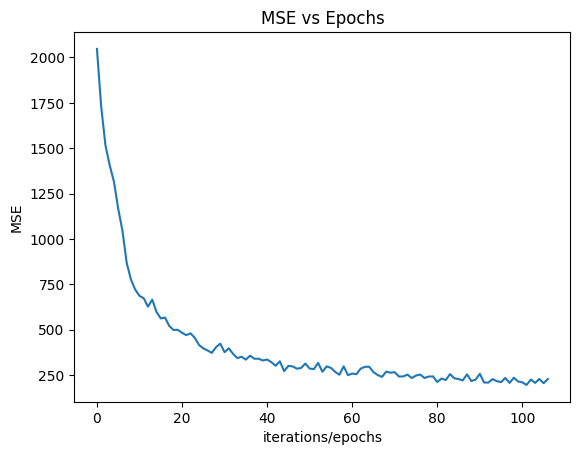

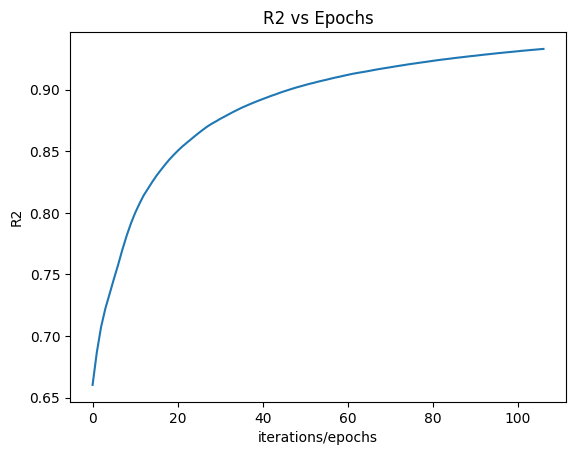

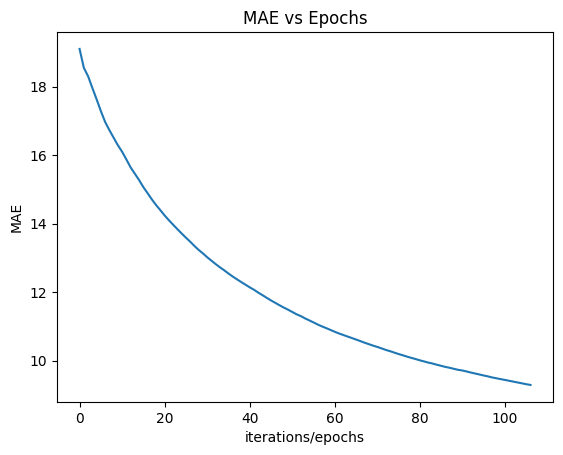

In [34]:
for epoch in range(n_epochs):
    ann_model.train()
    with tqdm.tqdm(batchstart, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch]
            y_batch = y_train[start:start+batch]
            # forward pass
            y_pred = ann_model(X_batch)
            loss = loss_func(y_pred, y_batch)
            # backward pass
            optimize.zero_grad()
            loss.backward()
            # update weights
            optimize.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    ann_model.eval()
    y_pred = ann_model(X_test)
    mse = loss_func(y_pred, y_test)
    mse = float(mse)
    metric.update(y_pred, y_test)
    mean_absolute_error.update(y_pred, y_test)
    r2 = metric.compute()
    mae = mean_absolute_error.compute()
    history.append(mse)
    historyMAE.append(mae)
    historyR2.append(r2)
    if mse < bestMSE:
        bestMSE = mse
        bestWeights = copy.deepcopy(ann_model.state_dict())
    if mae < bestMAE:
        bestMAE = mae
    if r2 > bestR2:
        bestR2 = r2


# restore model and return best accuracy
ann_model.load_state_dict(bestWeights)
print("MSE: %.2f" % bestMSE)
print("RMSE: %.2f" % np.sqrt(bestMSE))
print("MAE: %.2f" % bestMAE)
print("R2: %.2f" % bestR2)
plt.plot(history)
plt.xlabel('iterations/epochs')
plt.ylabel('MSE')
plt.title('MSE vs Epochs')
plt.show()
plt.plot(historyR2)
plt.xlabel('iterations/epochs')
plt.ylabel('R2')
plt.title('R2 vs Epochs')
plt.show()
plt.plot(historyMAE)
plt.xlabel('iterations/epochs')
plt.ylabel('MAE')
plt.title('MAE vs Epochs')
plt.show()

In [47]:
residual_tensor = y_pred - y_test

In [48]:
residual_numpy = residual_tensor.detach().numpy()

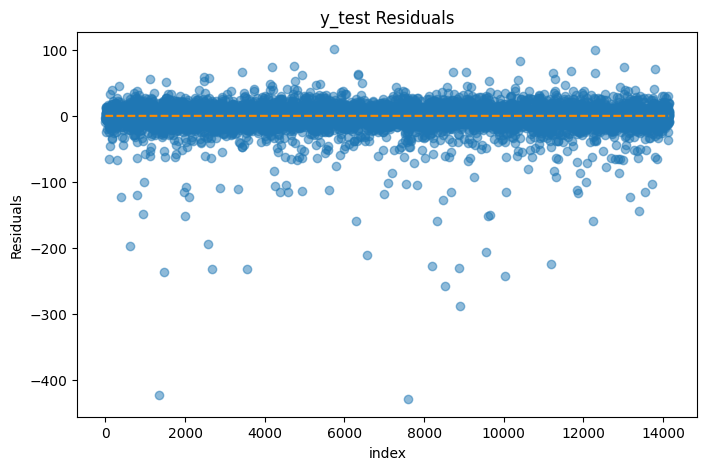

In [52]:
# Plotting the residuals
plt.subplots(figsize=(8, 5))

ax = plt.subplot(111)  # To remove spines

plt.scatter(x=range(0,len(y_test)), y=residual_numpy, alpha=0.5)
plt.plot(np.repeat(0, len(y_test)), color='darkorange', linestyle='--')
plt.title('y_test Residuals')
plt.ylabel('Residuals')
plt.xlabel('index')
plt.show()

A residual plot shows how good the developed model is. Since there are no patterns and the residuals are equally distributed around the zero line(except for a few outliers on the negative side) we can say that the developed model is unbiased.

In [53]:
y_test_numpy = y_test.detach().numpy()
y_pred_numpy = y_pred.detach().numpy()

In [64]:
compare_test_pred = pd.DataFrame({'y_test':y_test_numpy.ravel(), 'y_pred':y_pred_numpy.ravel()}, columns=['y_test','y_pred'])

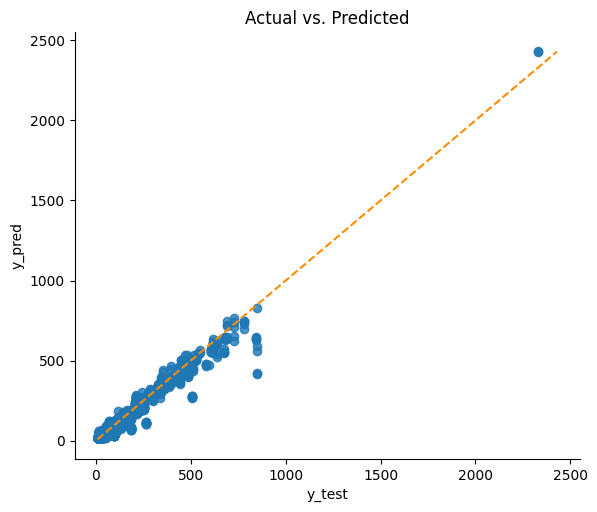

In [67]:
sns.lmplot(x='y_test', y='y_pred', data=compare_test_pred, fit_reg=False, height=5, aspect=1.2)

# lets plot the diagonal line
line_coords = np.arange(y_test_numpy.min(), y_pred_numpy.max())
plt.plot(line_coords, line_coords, color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()

Since the y_test vs y_pred scatter plot has all the values close to the line and without deviations, it is a good fit and not biased.

In [75]:
print("MAE: %.2f" % bestMAE)
print("MSE: %.2f" % bestMSE)
print("RMSE: %.2f" % np.sqrt(bestMSE))
print("R2: %.2f" % bestR2)

MAE: 9.18
MSE: 227.45
RMSE: 15.08
R2: 0.93
